# 2022-03-07 Spline interpolation

## Last time

* Runge phenomenon as ill conditioning
* Stability and Chebyshev polynomials
* Piecewise methods

## Today

* Accuracy of piecewise constant (nearest neighbor) interpolation
* Piecewise polynomial methods
* Splines
* Libraries

In [12]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

runge(x) = 1 / (1 + 10*x^2)

CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]

vcond (generic function with 1 method)

# Chebyshev polynomials
$$\begin{split}
T_0(x) &= 1 \\
T_1(x) &= x \\
T_{n+1}(x) &= 2 x T_n(x) - T_{n-1}(x)
\end{split}$$

In [29]:
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        #T[:, k] = x .* T[:, k-1]
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

vander_chebyshev (generic function with 2 methods)

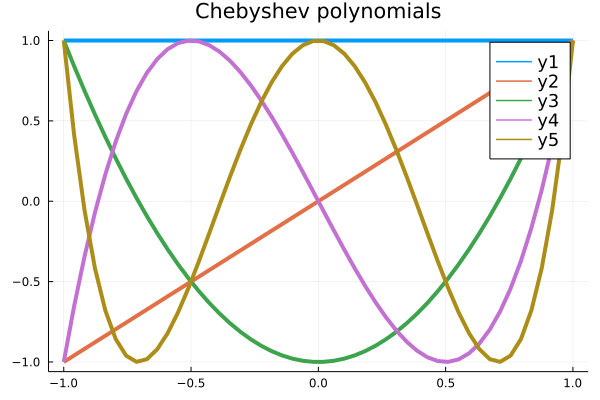

In [30]:
x = LinRange(-1, 1, 50)
plot(x, vander_chebyshev(x, 5), title="Chebyshev polynomials")

# Chebyshev polynomials are well-conditioned



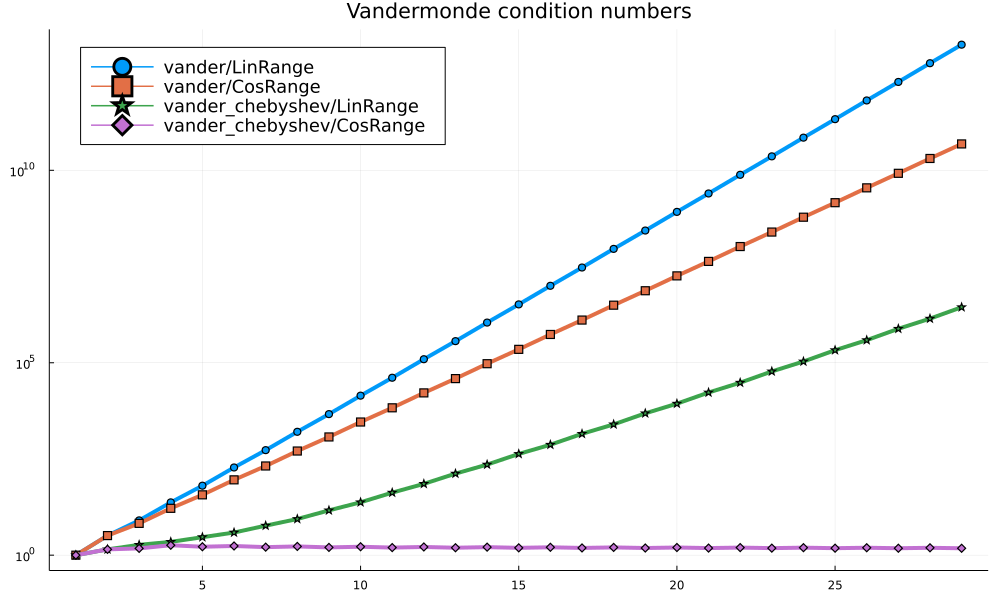

In [31]:
plot_vcond(mat, points) = plot!([
        cond(mat(points(-1, 1, n)))
        for n in 2:30], label="$mat/$points", marker=:auto, yscale=:log10)

plot(title="Vandermonde condition numbers", legend=:topleft, size=(1000, 600))
plot_vcond(vander, LinRange)
plot_vcond(vander, CosRange)
plot_vcond(vander_chebyshev, LinRange)
plot_vcond(vander_chebyshev, CosRange)

# Lagrange interpolating polynomials revisited

Let's re-examine the Lagrange polynomials as we vary the points.

cond(A) = 3.388221057514254


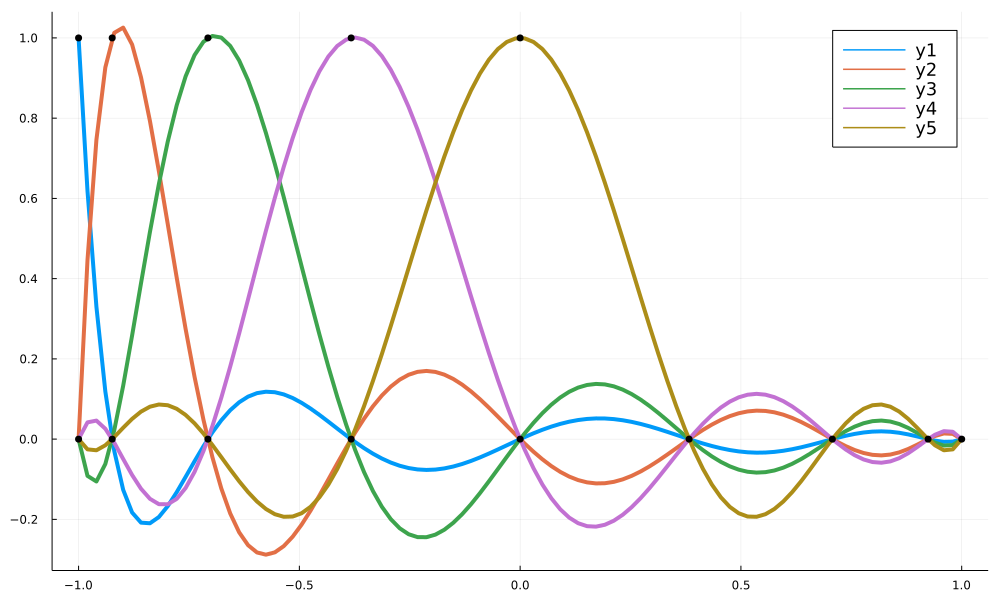

In [39]:
x = CosRange(-1, 1, 9) # CosRange?
s = LinRange(-1, 1, 100)
A = vander_chebyshev(s, length(x)) /
    vander_chebyshev(x)
@show cond(A)
plot(s, A[:,1:5], size=(1000, 600))
scatter!(x[1:5], ones(5), color=:black, label=nothing)
scatter!(x, zero(x), color=:black, label=nothing)

* Are there artifacts?

# Piecewise interpolation

In [41]:
function interp_nearest(x, s)
    A = zeros(length(s), length(x))
    for (i, t) in enumerate(s)
        loc = nothing
        dist = Inf
        for (j, u) in enumerate(x)
            if abs(t - u) < dist
                loc = j
                dist = abs(t - u)
            end
        end
        A[i, loc] = 1
    end
    A
end
interp_nearest(LinRange(-1, 1, 3), LinRange(0, 1, 4))

4×3 Matrix{Float64}:
 0.0  1.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0
 0.0  0.0  1.0

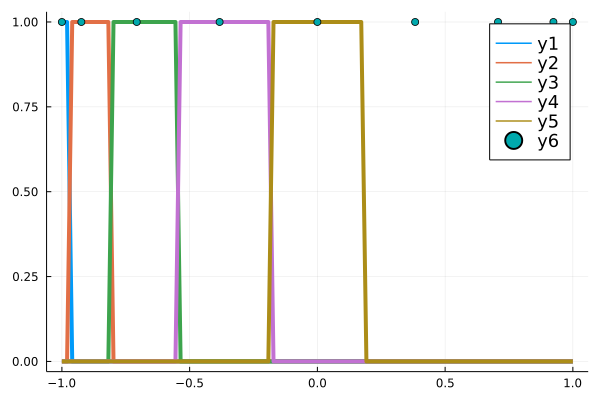

In [42]:
A = interp_nearest(x, s)
plot(s, A[:, 1:5])
scatter!(x, ones(length(x)))

## I don't see any visual artifacts


In [43]:
x = LinRange(-1, 1, 30)
A = interp_nearest(x, s)
cond(A)

1.414213562373095

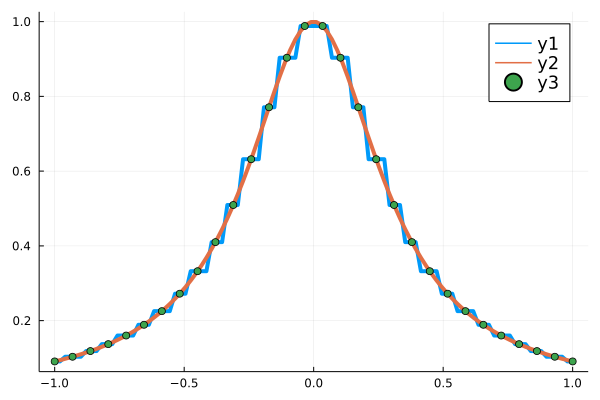

In [44]:
plot(s, A * runge.(x))
plot!(s, runge.(s))
scatter!(x, runge.(x))

In [15]:
function interp_chebyshev(x, xx)
    vander_chebyshev(xx, length(x)) * inv(vander_chebyshev(x))
end

function interp_monomial(x, xx)
    vander(xx, length(x)) * inv(vander(x))
end

function interp_error(ieval, x, xx, test)
    """Compute norm of interpolation error for function test
    using method interp_and_eval from points x to points xx.
    """
    A = ieval(x, xx)
    y = test.(x)
    yy = test.(xx)
    norm(A * y - yy, Inf)
end

function plot_convergence(ievals, ptspaces; xscale=:log10, yscale=:log10, maxpts=40)
    """Plot convergence rates for an interpolation scheme applied
    to a set of tests.
    """
    xx = LinRange(-1, 1, 100)
    ns = 2:maxpts
    fig = plot(title="Convergence",
        xlabel="Number of points",
        ylabel="Interpolation error",
        xscale=xscale,
        yscale=yscale,
        legend=:bottomleft,
        size=(1200, 800))
    for ieval in ievals
        for ptspace in ptspaces
            for test in [runge]
                errors = [interp_error(ieval, ptspace(-1, 1, n), xx, test)
                         for n in ns]
                plot!(ns, errors, marker=:circle, label="$ieval/$ptspace")
            end
        end
    end
    for k in [1, 2, 3]
        plot!(ns, ns .^ (-1.0*k), color=:black, label="\$n^{-$k}\$")
    end
    fig
end


plot_convergence (generic function with 1 method)

# So maybe it's not that accurate?


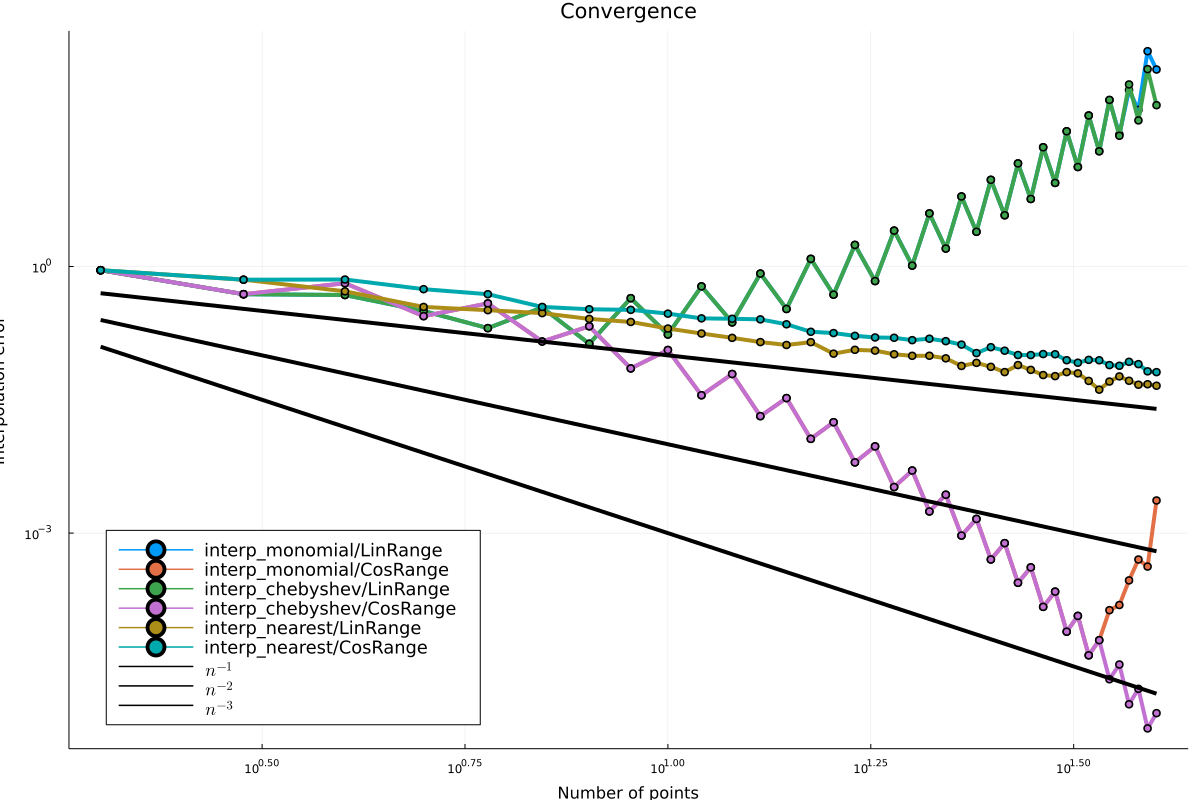

In [45]:
plot_convergence([interp_monomial, interp_chebyshev, interp_nearest], [LinRange, CosRange])

# How could we improve the accuracy?



# Cubic splines

* Piecewise cubic function
* Continuous values
* Continuous derivatives

In [24]:
function spline_interp_and_eval(x, s)
    n = length(x)
    function s_interp(y)
        delta = x[2:end] - x[1:end-1] # diff(x)
        Delta = diff(y)
        T = zeros(n+1, n+1)
        T[1,1] = 1
        for i in 2:n-1
            T[i, i-1:i+1] = [delta[i-1], 2*(delta[i-1] + delta[i]), delta[i]]
        end
        T[end,end] = 1
        rhs = zeros(n+1)
        rhs[2:end] = 3*(Delta[2:end] ./ delta[2:end] - Delta[1:end-1] ./ delta[1:end-1])
        c = T \ rhs
        S = zeros(n, 5)
        S[:, 1] = x[1:end-1]
        S[:, 3] = c[1:end-1]
        S[:, 5] = y[1:end-1]
        S[:, 2] = diff(c) ./ (3 * delta)
        S[:, 4] = Delta ./ delta - delta/3 .* (2*c[1:end-1] + c[2:end])
        S
    end
    
    function polyval(p, x)
        f = p[1]
        for c in p[2:end]
            f = f * x + c
        end
        f
    end

    function s_eval(S, s)
        f = zero(s)
        for (i, t) in s
            left = max(1, searchsortedfirst(S[:,1], t) - 1)
            f[i] = polyval(S[left, 2:end], t - S[left, 1])
        end
        f
    end
    
    A = zeros(length(s), length(x))
    aye = diagm(ones(length(x)))
    @show size(A), size(aye)
    for i in 1:length(x)
        e = aye[:, i]
        S = s_interp(e)
        A[:, i] = s_eval(S, s)
    end
    A
end

A = spline_interp_and_eval(x, s)

(size(A), size(aye)) = ((100, 30), (30, 30))


LoadError: DimensionMismatch("tried to assign 28 elements to 30 destinations")

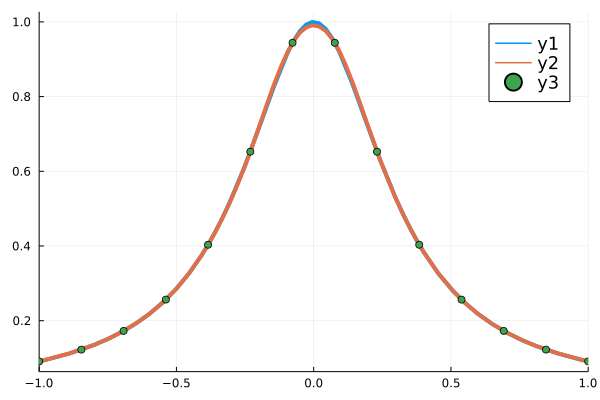

In [68]:
using Interpolations

x = LinRange(-1, 1, 14)
y = runge.(x)
flin = LinearInterpolation(x, y)
fspline = CubicSplineInterpolation(x, y)
plot([runge, t -> fspline(t)], xlims=(-1, 1))
scatter!(x, y)

In [66]:
xx = LinRange(-1, 1, 100)
norm(runge.(xx) - fspline.(xx))

0.01376551862282631